In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wield.iirrational.v2 import data2filter
from wield.control.AAA import tfAAA

In [197]:
def moku_read_TF_B(file_path):
    df = pd.read_csv(file_path,header=7)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Channel B Magnitude (dB)']
    y_data2 =df[' Channel B Phase (deg)']
    	 	
    return x_data, y_data1, y_data2

def plot_bode(frequencies: np.ndarray, H_values_list: list, labels: list):
    fig, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize=(8, 6))
    
    for H_values, label in zip(H_values_list, labels):
        ax_mag.semilogx(frequencies, 20 * np.log10(np.abs(H_values)), label=label)
        ax_phase.semilogx(frequencies, np.angle(H_values, deg=True), label=label)
    
    ax_mag.set_title("Bode Plot")
    ax_mag.set_ylabel("Magnitude (dB)")
    ax_mag.grid(True, which="both")
    ax_mag.legend()
    
    ax_phase.set_ylabel("Phase (degrees)")
    ax_phase.set_xlabel("Frequency (Hz)")
    ax_phase.grid(True, which="both")
    ax_phase.legend()
    
    plt.tight_layout()
    plt.show()
    
def db2mag(db):
    return 10**(db/20)

def mag2db(mag):
    return 20*np.log10(mag)


def fit_ASD_simp(freq, ASD, n_samples, relative_degree = -2, SNR = None):
    freq_downsampled,downsampled = downsample_data(freq,ASD,n_samples)
    barycentric = tfAAA(F_Hz=freq_downsampled, xfer=downsampled)
    all_z = barycentric.zeros
    all_p = barycentric.poles
    k = barycentric.gain
    
    for pid in range(len(all_p)):
        if np.real(all_p[pid])>0:
            all_p[pid]= - np.conjugate(all_p[pid])
    
    for zid in range(len(all_z)):
        if np.real(all_z[zid])>0:
            all_z[zid]= - np.conjugate(all_z[zid])
    
    return all_z, all_p, k


def fit_ASD(freq, ASD, n_samples, relative_degree = -2, SNR = None):
    freq_downsampled,downsampled = downsample_data(freq,ASD,n_samples)
    barycentric = tfAAA(F_Hz=freq_downsampled, xfer=downsampled)
    all_z = barycentric.zeros
    all_p = barycentric.poles
    k = barycentric.gain
    
    print(all_p)
    print(all_z)
            
    
    if SNR is None:
        #SNR = np.ones_like(freq_downsampled)
        SNR = freq_downsampled**1.25

    iir_results = data2filter(
        F_Hz=freq_downsampled,
        xfer=downsampled,
        mode='reduce',
        zeros=tuple(np.array(all_z) / (np.pi * 2)), 
        poles=tuple(np.array(all_p) / (np.pi * 2)),
        gain=k,
        SNR_phase_rel=0,
        SNR=SNR,
        relative_degree=relative_degree,
        # resavg_RthreshOrdDn=1.01,
        baseline_only=True,
        # coding_map=fitters_ZPK.codings_s.coding_maps.RI
        # trust_iir_results = data2filter(SNR = True,
        )

    inp = {}
    inp['freq'] = freq
    inp['ASD'] = ASD
    inp['label'] = 'measured ASD'

    dwn = {}
    dwn['freq'] = freq_downsampled
    dwn['ASD'] = downsampled
    dwn['label'] = 'downsampled data'

    bary = {}
    bary['freq'] = freq
    bary['TF'] = barycentric(freq)
    bary['ASD'] = abs(barycentric(freq))
    bary['label'] = 'AAA fit (order {})'.format(barycentric.order)

    result = {}
    result['freq'] = freq
    result['TF'] = iir_results.fitter.xfer_eval(freq)
    result['ASD'] = abs(iir_results.fitter.xfer_eval(freq))
    result['label'] = 'data2filter fit (order {})'.format(iir_results.order)

    return inp, dwn, bary, result, iir_results


# def downsample_data(freq, PSD, n_samples):
#     F_groups = np.geomspace(min(freq), max(freq), n_samples) # originally 200 length
#     print(min(freq), max(freq))
#     idx_groups = np.searchsorted(freq, F_groups)
#     print(idx_groups)
#     idx_pairs = list(zip(idx_groups[:-1], idx_groups[1:]))
#     print(idx_pairs)
    
#     lPSDs_med = []
#     freq_downsampled = []
#     for idx1, idx2 in idx_pairs:
#         if idx1 == idx2:
#             continue
#         lPSDs_med.append(
#             np.nanmedian(PSD[idx1:idx2])
#         )
#         freq_downsampled.append(np.mean(freq[idx1:idx2]))

#     return np.asarray(freq_downsampled), np.asarray(lPSDs_med)


# import numpy as np

def downsample_data(freq, PSD, n_samples):
    """
    Downsample frequency and PSD arrays for plotting.

    Parameters:
        freq (array-like): Frequency values.
        PSD (array-like): Power spectral density values.
        n_samples (int): Desired number of points after downsampling.

    Returns:
        tuple: (freq_ds, PSD_ds) downsampled frequency and PSD arrays.
    """
    freq = np.asarray(freq)
    PSD = np.asarray(PSD)
    
    if len(freq) != len(PSD):
        raise ValueError("freq and PSD must be the same length")
    if n_samples >= len(freq):
        return freq, PSD  # No downsampling needed
    
    indices = np.linspace(0, len(freq) - 1, n_samples).astype(int)
    return freq[indices], PSD[indices]




data = moku_read_TF_B(r"C:\Users\torre\Downloads\AOM TFs\AOM TFs\AOM_locked_sweepon_piezo_higher_res_20250311_140112_Traces.csv")

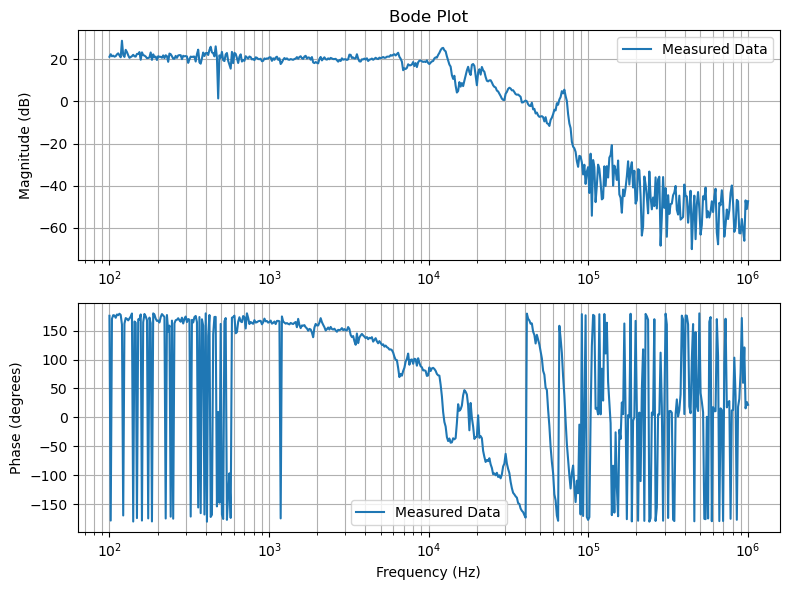

In [3]:
M = 1 #Assuming aom response is flat and unity
V = 5 #VCO response is flat and 5 MHz/V
gamma = 2*125e6/1550e-9 #fsr over lambda or f over L gives same ish number? comes from delta f over f = delta L over L

complex_data = db2mag(data[1])*np.exp(1j*(data[2])*np.pi/180)

plot_bode(data[0],[np.array(complex_data)],["Measured Data"])

In [4]:
def pure_integrator(f: float, f_unity: float) -> complex:
    return 1 / (1j * 2 * np.pi * f / f_unity)

f_unity = 44260 
frequencies = data[0]
Kontroller = np.array([pure_integrator(f, f_unity) for f in frequencies])

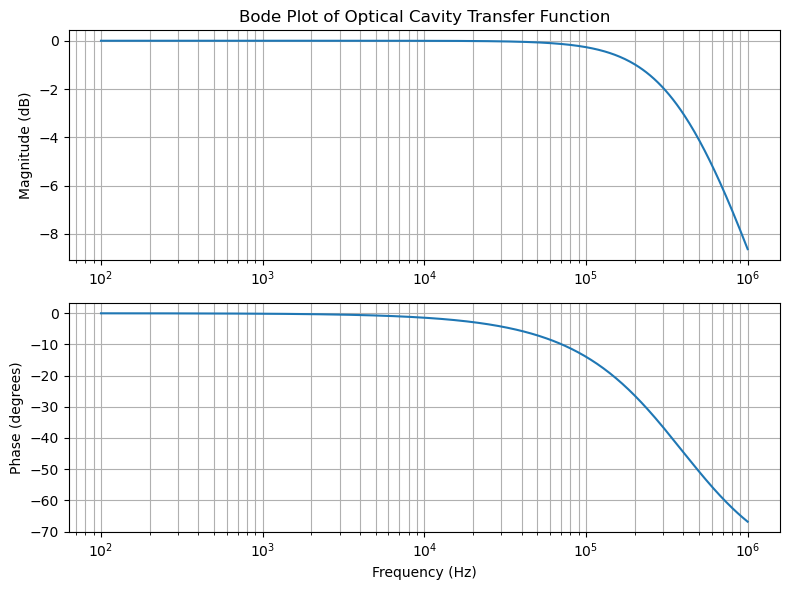

In [5]:
def cavity_transfer_function(f: float, L: float, r1: float, r2: float) -> complex:
    c = 3e8
    FSR = c / L
    phi = 2 * np.pi * f / FSR
    
    numerator = np.sqrt(1 - r1**2) * np.sqrt(1 - r2**2)
    denominator = 1 - r1 * r2 * np.exp(-1j * phi)
    
    return numerator / denominator

L = 2.41
transmissivity = .01
r1, r2 = 1-transmissivity,1-transmissivity
scaling_factor = 2.94*(1/10.)/5e6
cavity_response = np.array([cavity_transfer_function(f, L, r1, r2) for f in frequencies])#*scaling_factor

fig, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize=(8, 6))

ax_mag.semilogx(frequencies, 20 * np.log10(np.abs(cavity_response)))
ax_mag.set_title("Bode Plot of Optical Cavity Transfer Function")
ax_mag.set_ylabel("Magnitude (dB)")
ax_mag.grid(True, which="both")

ax_phase.semilogx(frequencies, np.angle(cavity_response, deg=True))
ax_phase.set_ylabel("Phase (degrees)")
ax_phase.set_xlabel("Frequency (Hz)")
ax_phase.grid(True, which="both")

plt.tight_layout()
plt.show()

In [6]:
undo_factor =  cavity_response * Kontroller/ (1-cavity_response*Kontroller*V*M)*gamma

piezo_TF = complex_data / undo_factor

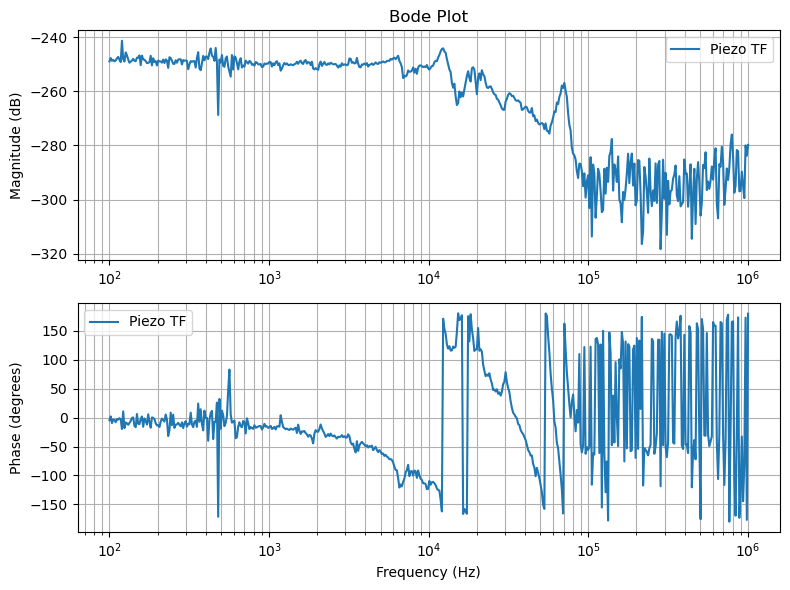

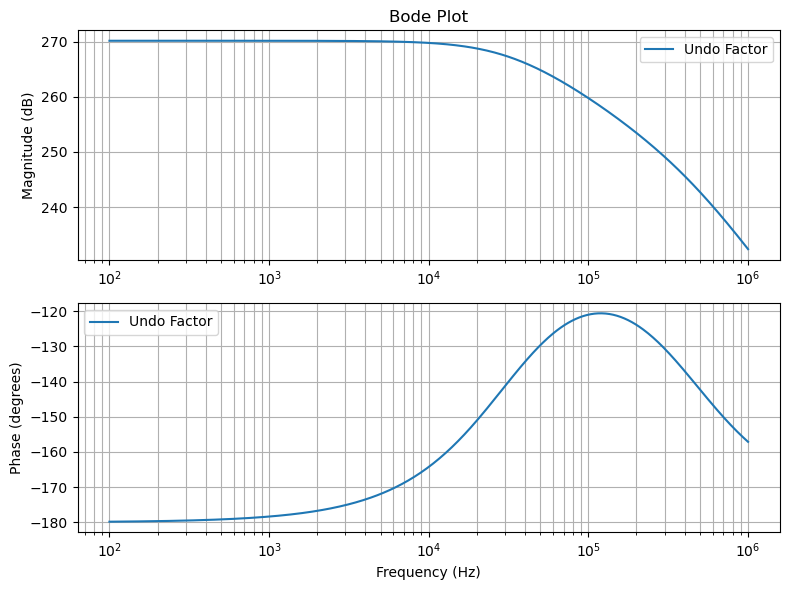

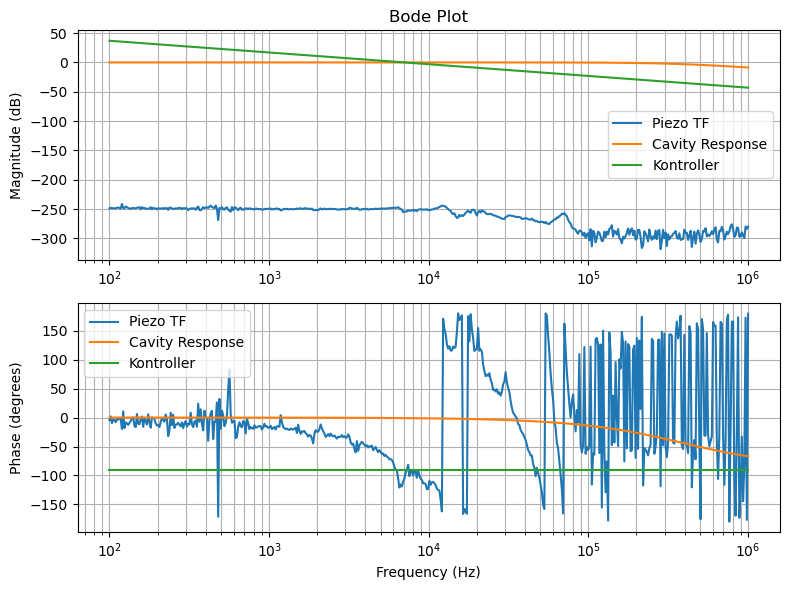

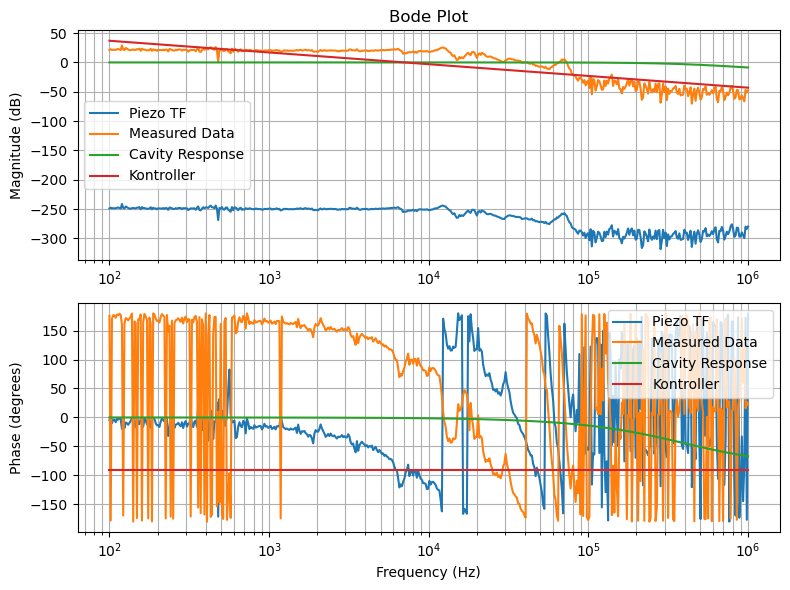

In [7]:
plot_bode(data[0],[piezo_TF],["Piezo TF"])
plot_bode(data[0],[undo_factor],["Undo Factor"])
plot_bode(data[0],[piezo_TF,cavity_response,Kontroller],["Piezo TF","Cavity Response","Kontroller"])
plot_bode(data[0],[piezo_TF,complex_data,cavity_response,Kontroller],["Piezo TF","Measured Data","Cavity Response","Kontroller"])



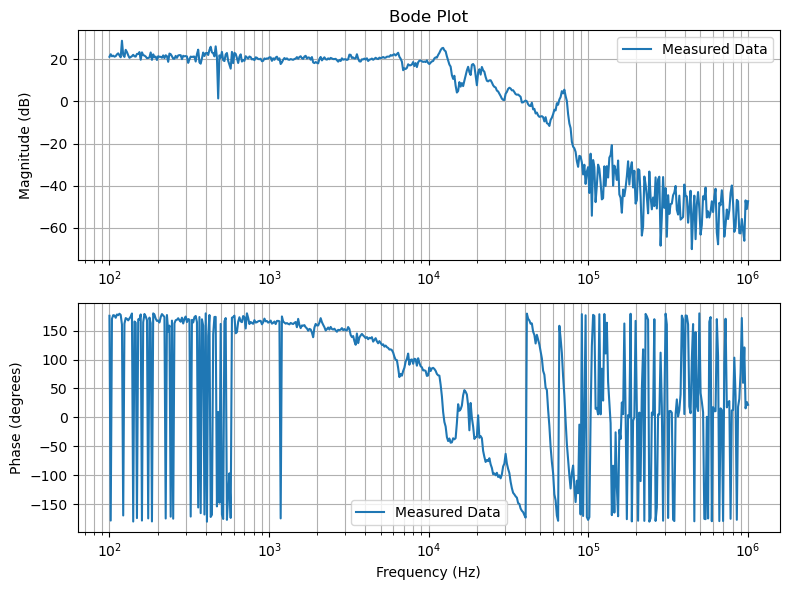

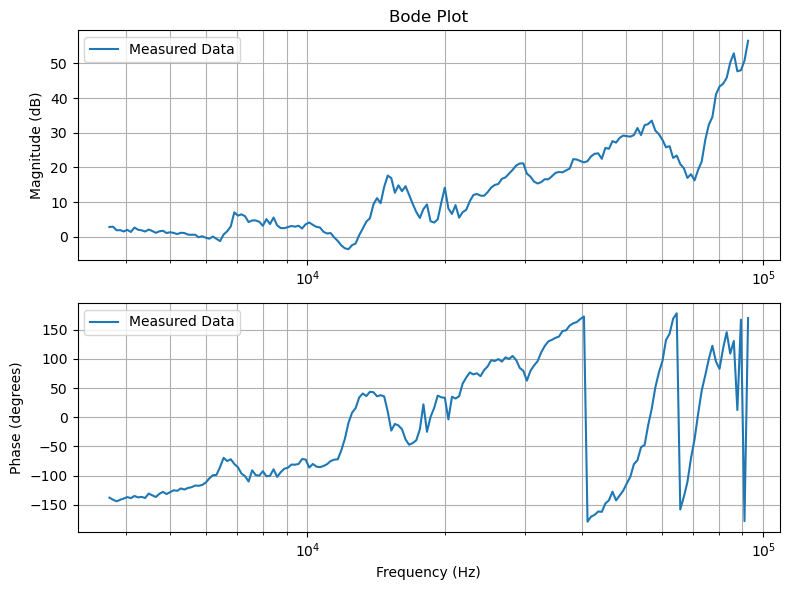

In [198]:
complex_data = db2mag(data[1])*np.exp(1j*(data[2])*np.pi/180)
plot_bode(data[0],[np.array(complex_data)],["Measured Data"])

rescale = np.average(np.abs(complex_data[-10:-1]))

rescaled_complex_data = complex_data/rescale
#plot_bode(data[0],[np.array(rescaled_complex_data)],["Measured Data"])

inverted = 1/np.array(rescaled_complex_data)[-380:-200]

plot_bode(np.array(data)[0,-380:-200],[np.array(inverted)],["Measured Data"])


In [247]:
fit_fq = np.array(data[0])[::-1]
fit_mag = np.array(np.abs(1/complex_data))[::-1]

select = (fit_fq > 1e3) & (fit_fq < 1e5) #make a mask for the frequency range of interest

fit_fq = fit_fq[select]
fit_mag = fit_mag[select]

inp, dwn, bary, result, iir_results = fit_ASD(fit_fq, fit_mag, 43)
#E_z, E_p, E_k = fit_ASD_simp(fit_fq, fit_mag, 30)

[ 5.38289520e+03 +67680.95280753j  5.38289520e+03 -67680.95280753j
 -1.81142597e-10 +47665.85392191j -1.81142597e-10 -47665.85392191j
  6.19793603e-11 +32024.40110904j  6.19793603e-11 -32024.40110904j
 -6.46474675e+03 +19526.61293593j -6.46474675e+03 -19526.61293593j
  6.46474675e+03 +19526.61293593j  6.46474675e+03 -19526.61293593j
 -4.83633766e+02 +14261.44266124j -4.83633766e+02 -14261.44266124j
  4.83633766e+02 +14261.44266124j  4.83633766e+02 -14261.44266124j
 -1.20411279e-12  +9743.2732721j  -1.20411279e-12  -9743.2732721j
 -5.79507419e-13  +6954.54286494j -5.79507419e-13  -6954.54286494j
 -2.08943097e-11  +4866.2559695j  -2.08943097e-11  -4866.2559695j
  1.31602153e-11  +3834.05604704j  1.31602153e-11  -3834.05604704j
  2.55156184e-11     +0.j         -1.41053750e-11  +1823.05570244j
 -1.41053750e-11  -1823.05570244j  4.24479510e-12  +1351.72602302j
  4.24479510e-12  -1351.72602302j -5.38289520e+03 -67680.95280753j
 -5.38289520e+03 +67680.95280753j  8.61475493e-10-118542.9434187

3W   0.01    The number of effective data points N=(ΣW^2)^2/(ΣW^4)=1.70e-01*len(W)
             [where W=SNR] is below the configured 'SNR_regularize_scale'=10,
             given the maximum SNR=1768291.0715839665. Now Finding an SNR ceiling that balances
             the ratio with max SNR.
3W   0.01    Using SNR<6473.727528898342 ceiling.
3W   0.06  Fitter_checkpoint improvement succeed, None
3W   0.16    Fitter_checkpoint improvement succeed, None


5P   0.37  zero flipping, maxzp 17, residuals=6.23e+07, 8.47e+07, reldeg=0
5P   0.87  zero flipped, maxzp 17, residuals=6.04e+07, reldeg=0
5P   0.98  zero flipped, maxzp 17, residuals=5.60e+07, reldeg=0
5P   1.13  zero flipped, maxzp 17, residuals=5.42e+07, reldeg=0
5P   1.20  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.22  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.24  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.26  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.28  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.30  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.33  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.36  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.38  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.40  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.43  zero flipped, maxzp 17, residuals=5.28e+07, reldeg=0
5P   1.45  zero flipped, maxz

3W   3.89    Fitter_checkpoint improvement succeed, None
3W   5.08    Fitter_checkpoint improvement succeed, None


5P   5.08    order reduced to 13, residuals=2.32e+07, reldeg=0


3W   6.69    Fitter_checkpoint improvement succeed, None


5P   6.69    order reduced to 12, residuals=1.72e+07, reldeg=0


3W   7.29    Fitter_checkpoint improvement succeed, None


5P   7.29    order reduced to 11, residuals=1.68e+07, reldeg=0


3W   7.98    Fitter_checkpoint improvement succeed, None


5P   7.98    order reduced to 11, residuals=4.56e+06, reldeg=-1


3W   8.61    Fitter_checkpoint improvement succeed, None


5P   8.61    order reduced to 9, residuals=4.54e+06, reldeg=-1


3W  10.46    Fitter_checkpoint improvement succeed, None


5P  10.46    order reduced to 8, residuals=4.19e+06, reldeg=-1
2A  10.73  Baseline fit residuals: 4.19e+06, at order 8
BASELINE:  8
------------:investigations:
2I  10.75    max(z, p)        ChiSq.
                   order     avg. res.        med. res.    max. res.
             -----------  ------------  ---------------  -----------
                       8   4.18832e+06  749181           1.25731e+07
                      31  -1.93696e+08       3.1845e+07  7.05101e+08


3W  10.73  Fitter_checkpoint improvement succeed, None


In [248]:
from wield.control import SISO
E_p = iir_results.fitter.poles.fullplane
E_z = iir_results.fitter.zeros.fullplane
E_k = iir_results.fitter.gain

E_zpk = SISO.zpk(E_z, E_p, E_k, convention='IIRrational').flip_to_stable()
E_fr = E_zpk.fresponse(f=np.array(data)[0,-380:-1])

print(E_zpk.z)
print(E_zpk.p)
print(E_zpk.k)


[-65078.62952649     +0.j          -2740.59911015+435018.16862948j
  -2740.59911015-435018.16862948j -12454.43288839 +84403.89212546j
 -12454.43288839 -84403.89212546j -22256.21443922+119142.38212183j
 -22256.21443922-119142.38212183j]
[-286436.04649197+296108.92657561j -286436.04649197-296108.92657561j
 -198063.76195517+642167.83712013j -198063.76195517-642167.83712013j
   -2721.73719041 +97003.97571282j   -2721.73719041 -97003.97571282j
 -256181.25759851+700295.55705016j -256181.25759851-700295.55705016j]
-30020102.75486105


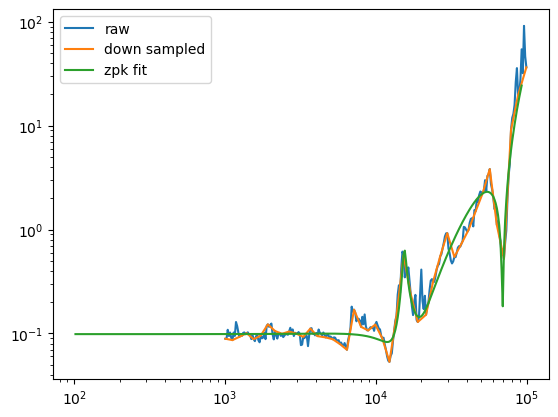

In [254]:
# plot_bode(np.array(data)[0,-380:-1],[np.array(inverted),*E_fr.fplot_mag],["Measured Data", '2'])
#plot_bode(dwn['freq'],[dwn['ASD']],["Measured Data", '2'])
# plot_bode(E_fr,[E_fr.fplot_mag],["Measured Data"])
from matplotlib import pyplot as plt 

plt.loglog(fit_fq,fit_mag,label = 'raw')
plt.loglog(dwn['freq'],dwn['ASD'],label = 'down sampled')
plt.loglog(*E_fr.fplot_mag,label = 'zpk fit')
plt.legend()

In [253]:
from scipy.signal import bilinear_zpk, zpk2sos

def zpk2mokuIIR(az,ap,ak,fs = 39.063e6):
    samplerates = [305.28e3, 4.8828e6, 39.063e6]
    if samplerates.count(fs) == 0:
        raise Exception("{} is not a valid sample rate for a Moku Pro IIR filter".format(fs))

    dz,dp,dk = bilinear_zpk(az,ap,ak,fs)
    sos = zpk2sos(dz,dp,dk)

    if len(sos) > 4:
        raise Exception("{} second-order stages is more than the Moku's maximum of 4".format(len(sos)))

    mokusos = []

    for section in sos:
        mokusos.append([1/section[3],section[0],section[1],section[2],section[4]/section[3],section[5]/section[3]])

    return mokusos

moku_data = zpk2mokuIIR(E_zpk.z,E_zpk.p,E_zpk.k,)
with open("output.txt", "w") as f:
    f.write("1.0\n")
    for row in moku_data:
        line = ", ".join(f"{x:.16f}" for x in row)  # Keeps full precision
        f.write(line + "\n")